# **FIFA19**

## **Goal: Try to utilize players' attributes to classify their position on the field**

![alt text](https://i.ytimg.com/vi/qTz8ZhNrEDA/maxresdefault.jpg)

# **Ingest**

### **Import packages**

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

### **Overview the Data**

In [2]:
# Read in the dataset
fifa = pd.read_csv("../input/data.csv")
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [3]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

In [4]:
fifa.describe()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18147.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,9103.000000,214298.338606,25.122206,66.238699,71.307299,1597.809908,1.113222,2.947299,2.361308,19.546096,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,42.863153,52.711933,58.369459,64.614076,64.726967,63.503607,61.836610,63.966573,55.460047,65.089432,63.219946,65.311967,47.109973,55.868991,46.698276,49.958478,53.400903,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,5256.052511,29965.244204,4.669943,6.908930,6.136496,272.586016,0.394031,0.660456,0.756164,15.947765,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,17.478763,15.327870,16.686595,14.927780,14.649953,14.766049,9.010464,14.136166,17.237958,11.820044,15.894741,12.557000,19.260524,17.367967,20.696909,19.529036,14.146881,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,0.000000,16.000000,16.000000,46.000000,48.000000,731.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4551.500000,200315.500000,21.000000,62.000000,67.000000,1457.000000,1.000000,3.000000,2.000000,8.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,9103.000000,221759.000000,25.000000,66.000000,71.000000,1635.000000,1.000000,3.000000,2.000000,17.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,13654.500000,236529.500000,28.000000,71.000000,75.000000,1787.000000,1.000000,3.000000,3.000000,26.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,18206.000000,246620.000000,45.000000,94.000000,95.000000,2346.000000,5.000000,5.000000,5.000000,99.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,94.000000,93.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,97.000000,94.000

# **Data Preprocessing**

### **Select the columns we want**

Dropping all the Goal Keepers because they have totally different attributes compared to players in other positions.

In [5]:
df2 = fifa.loc[:, 'Crossing':'Release Clause']
df1 = fifa[['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Club', 'Value', 'Wage', 'Preferred Foot', 'Skill Moves', 'Position', 'Height', 'Weight']]
df3 = pd.concat([df1, df2], axis=1)
df = df3.drop(['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'], axis=1)
df = df.loc[df['Position'] != 'GK', :]

### **Drop null value**

In [6]:
df = df.dropna()

### **Convert string data to numerical data**

In order to do EDA, string values need to be changed into numerical values.

In [7]:
def value_to_int(df_value):
    try:
        value = float(df_value[1:-1])
        suffix = df_value[-1:]

        if suffix == 'M':
            value = value * 1000000
        elif suffix == 'K':
            value = value * 1000
    except ValueError:
        value = 0
    return value
  
df['Value_float'] = df['Value'].apply(value_to_int)
df['Wage_float'] = df['Wage'].apply(value_to_int)
df['Release_Clause_float'] = df['Release Clause'].apply(lambda m: value_to_int(m))

In [8]:
def weight_to_int(df_weight):
    value = df_weight[:-3]
    return value
  
df['Weight_int'] = df['Weight'].apply(weight_to_int)
df['Weight_int'] = df['Weight_int'].apply(lambda x: int(x))

In [9]:
def height_to_int(df_height):
    try:
        feet = int(df_height[0])
        dlm = df_height[-2]

        if dlm == "'":
            height = round((feet * 12 + int(df_height[-1])) * 2.54, 0)
        elif dlm != "'":
            height = round((feet * 12 + int(df_height[-2:])) * 2.54, 0)
    except ValueError:
        height = 0
    return height

df['Height_int'] = df['Height'].apply(height_to_int)

In [10]:
df.loc[df['Preferred Foot'] == 'Left', 'Preferred_Foot'] = 1
df.loc[df['Preferred Foot'] == 'Right', 'Preferred_Foot'] = 0

### **Redefine Position**

Only focus on three groups on the upper level, which are "Strikers", "Midfielder", and "Defender".
For example: "CAM" Central Attacking Midfielder and "RDM" Right Defending Midfielder are all categorized to be "Midfielder".

In [11]:
for i in ['ST', 'CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW']:
  df.loc[df.Position == i , 'Pos'] = 'Strikers' 

for i in ['CAM', 'CDM', 'LCM', 'CM', 'LAM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM']:
  df.loc[df.Position == i , 'Pos'] = 'Midfielder' 

for i in ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB']:
  df.loc[df.Position == i , 'Pos'] = 'Defender' 

#df.loc[df['Pos'] == 'Strikers', 'Pos_int'] = 1
#df.loc[df['Pos'] == 'Midfielder', 'Pos_int'] = 2
#df.loc[df['Pos'] == 'Defender', 'Pos_int'] = 3

### **Keep the preprocessed data**

In [12]:
df = df.drop(['Value', 'Wage', 'Release Clause', 'Weight', 'Height'], axis=1)

### **Choose players with more than 70 overall rating**

The reason of only filtering out 70+ rating players is to see how good players define their position and to find out how to become good player by choosing the right position based on player's attributes.

In [13]:
df = df[df['Overall'] >=70]
df.head()

,ID,Name,Age,Nationality,Overall,Club,Preferred Foot,Skill Moves,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Value_float,Wage_float,Release_Clause_float,Weight_int,Height_int,Preferred_Foot,Pos
0,158023,L. Messi,31,Argentina,94,FC Barcelona,Left,4.0,RF,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,110500000.0,565000.0,226500000.0,159,170.0,1.0,Strikers
1,20801,Cristiano Ronaldo,33,Portugal,94,Juventus,Right,5.0,ST,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,77000000.0,405000.0,127100000.0,183,188.0,0.0,Strikers
2,190871,Neymar Jr,26,Brazil,92,Paris Saint-Germain,Right,5.0,LW,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,118500000.0,290000.0,228100000.0,150,175.0,0.0,Strikers
4,192985,K. De Bruyne,27,Belgium,91,Manchester City,Right,4.0,RCM,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,102000000.0,355000.0,196400000.0,154,180.0,0.0,Midfielder
5,183277,E. Hazard,27,Belgium,91,Chelsea,Right,4.0,LF,81.0,84.0,61.0,89.0,80.0,95.0,83.0,79.0,83.0,94.0,94.0,88.0,95.0,90.0,94.0,82.0,56.0,83.0,66.0,80.0,54.0,41.0,87.0,89.0,86.0,91.0,34.0,27.0,22.0,93000000.0,340000.0,172100000.0,163,173.0,0.0,Strikers


# **EDA**

### **Distribution of each position**

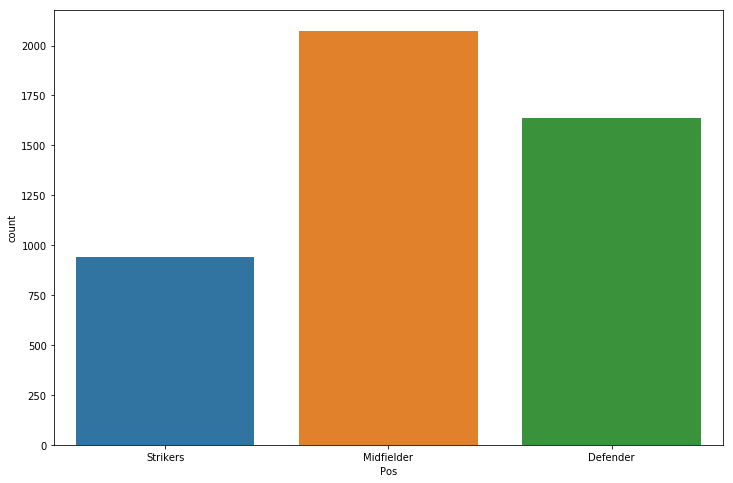

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(x = 'Pos', data =df)

The total count of Midfielder is larger than that of Strikers because there are more specified positions for Midfielder.

<Figure size 864x576 with 0 Axes>

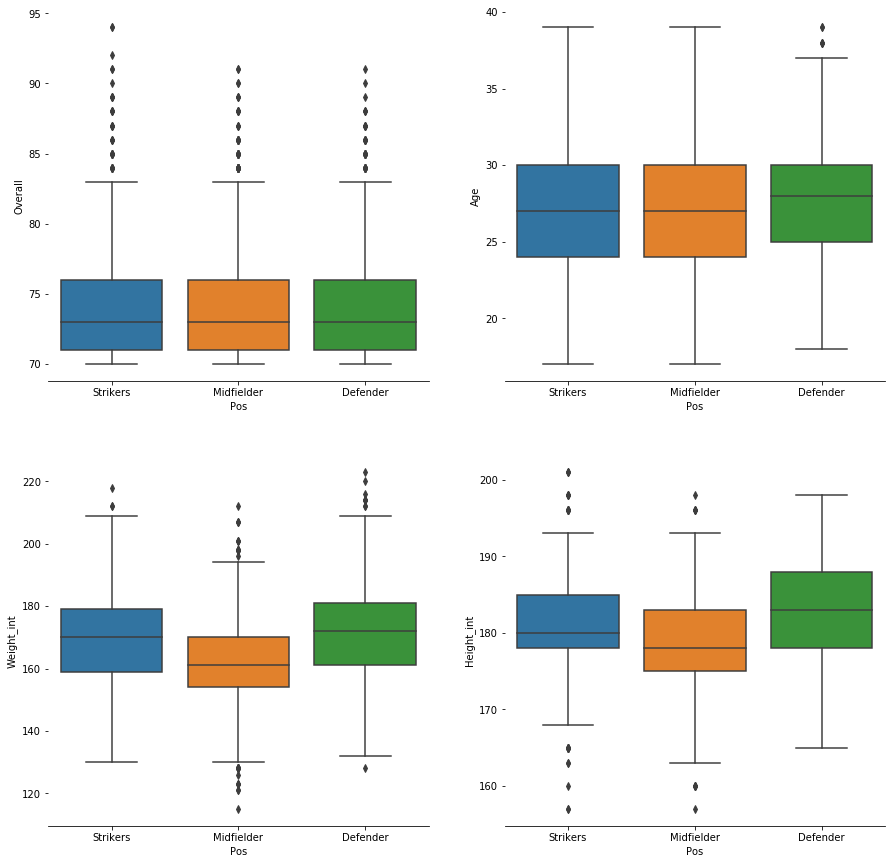

In [15]:
plt.figure(figsize=(12, 8))

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=False)
sns.despine(left=True)

sns.boxplot('Pos', 'Overall', data = df, ax=axes[0, 0])
sns.boxplot('Pos', 'Age', data = df, ax=axes[0, 1])

sns.boxplot('Pos', 'Height_int', data = df, ax=axes[1, 1])
sns.boxplot('Pos', 'Weight_int', data = df, ax=axes[1, 0])


* There is no significant difference in Overall Rating among all three positions, excluded from the prediction model 
* Defender has a smaller deviation in Age.
* Midfielder tends to be shorter and lighter since they need to be more flexible in passing and dribbling.

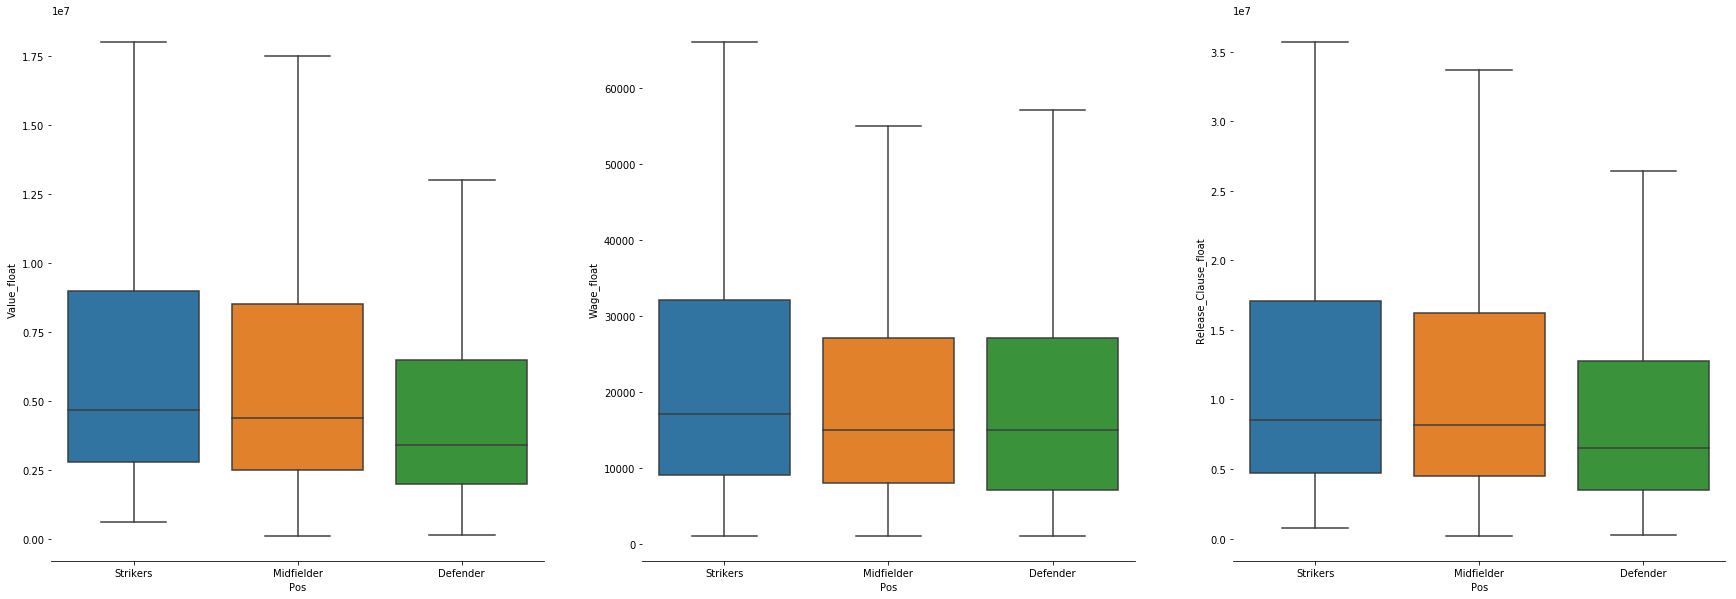

In [16]:
f, axes = plt.subplots(ncols= 3, figsize=(30, 10), sharex=False)
sns.despine(left=True)

sns.boxplot('Pos', 'Value_float', data = df, showfliers=False, ax=axes[0])
sns.boxplot('Pos', 'Wage_float', data = df, showfliers=False, ax=axes[1])
sns.boxplot('Pos', 'Release_Clause_float', data = df, showfliers=False, ax=axes[2])

* Strikers tend to have higher value, wage, and Release Clause compared to other positions and Defender is the lowest.
* It aligns to a fact that, normally, people care more about attacking but ignore the true value of defending.

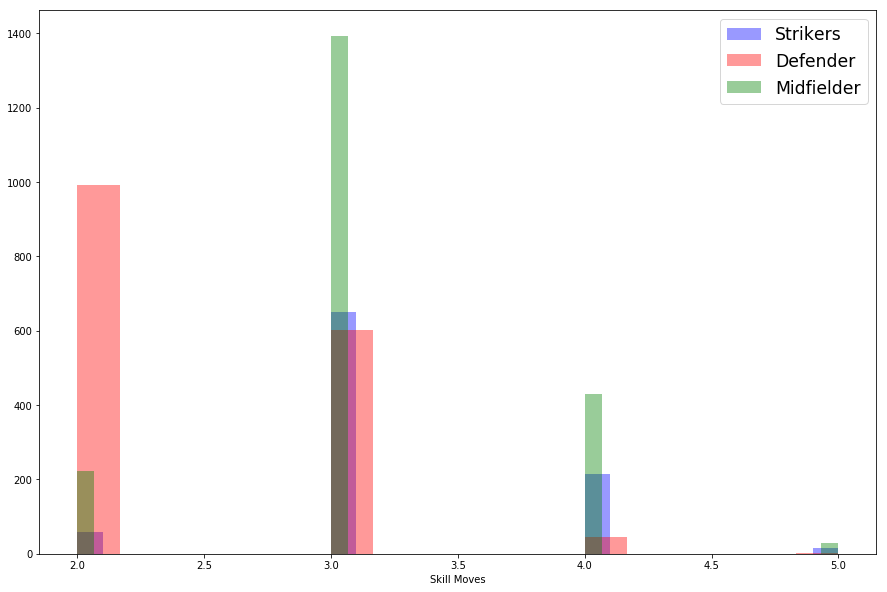

In [17]:
plt.figure(figsize=(15,10))

a = df[df['Pos'] == 'Strikers']
b = df[df['Pos'] == 'Defender']
c = df[df['Pos'] == 'Midfielder']

sns.distplot(a['Skill Moves'], color='blue', label = 'Strikers', kde=False)
sns.distplot(b['Skill Moves'], color='red', label = 'Defender',  kde=False)
sns.distplot(c['Skill Moves'], color='green', label = 'Midfielder',  kde=False)

plt.legend(fontsize = 'xx-large')


Defender has a much lower skill move score compared to Strikers and Midfielder, which could be one of the reasons why Defender values less than the other two positions. Since Defender cannot perform eye-catching moves due to their low skills move scores, they cannot show their value in a straight forward way.

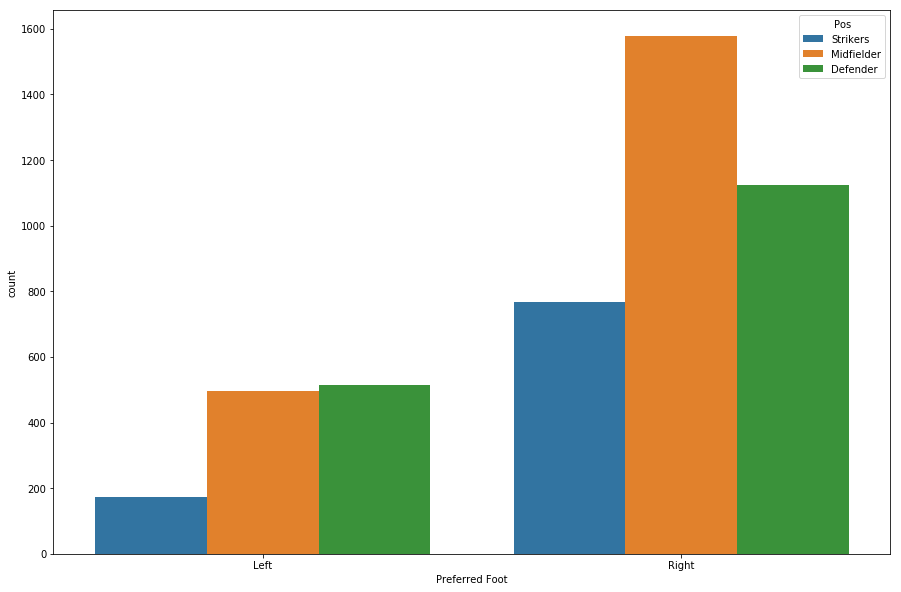

In [18]:
plt.figure(figsize=(15,10))
sns.countplot(x='Preferred Foot', data=df, hue='Pos')

Compared to Strikers and Midfielder, Defender is more balanced on their foot, even though all three positions are heavily right feet used.

# **Modeling**

### **Train test data split**

In [19]:
cols = ['Age', 'Skill Moves', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'Value_float', 'Wage_float', 'Release_Clause_float',
       'Weight_int', 'Height_int', 'Preferred_Foot']


y = ['Pos']
x = cols
x_train, x_test, y_train, y_test = train_test_split(df[x],df[y], test_size=0.2)

### **Model comparing and selecting**

In [20]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
#Common Model Evaluations
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### **Machine Learning Algorithm (MLA) Selection and Initialization**

Try different models to see which one provides the best accuracy.

In [21]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.SGDClassifier(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    #xgboost: 
    XGBClassifier()    
    ]

#split dataset in cross-validation with this splitter class
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y_train[y]

#index through MLA and save performance to table
row_index = 1
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    
    #score model with cross validation
    cv_results = model_selection.cross_validate(alg,x_train[x],  y_train[y], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions 
    alg.fit(x_train[x],  y_train[y])
    MLA_predict[MLA_name] = alg.predict(x_train[x])
    
    row_index+=1

#print and sort table
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
16,XGBClassifier,0.93675,0.873882,0.0237898,0.751738
4,GradientBoostingClassifier,0.961504,0.869589,0.0212918,1.35308
14,LinearDiscriminantAnalysis,0.875022,0.865921,0.0228149,0.0288462
5,RandomForestClassifier,0.989839,0.855188,0.025356,0.0544745
2,BaggingClassifier,0.989794,0.853399,0.0258343,0.243624
3,ExtraTreesClassifier,1,0.847406,0.0266505,0.0328574
15,QuadraticDiscriminantAnalysis,0.87265,0.835242,0.0221536,0.0160252
12,DecisionTreeClassifier,1,0.792934,0.0323621,0.0439605
13,ExtraTreeClassifier,1,0.752504,0.0214686,0.00701456
1,AdaBoostClassifier,0.732363,0.71941,0.0518111,0.334534


### **Grid search for XGBClassifier**

In [22]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from datetime import datetime

### **Set timer to record the time**

In [23]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### **Set a range of values for different parameters **

In [24]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [25]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

### **Test different combinations**

In [26]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(x_train,y_train), verbose=3, random_state=1001 )

start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(x_train,y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.5min finished



 Time taken: 0 hours 1 minutes and 40.39 seconds.


### **Print out the best combination of parameters**

In [27]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)


 All results:
{'mean_fit_time': array([17.77227966, 24.93673674, 22.00040778, 17.66305629, 17.88402653]), 'std_fit_time': array([0.43752866, 1.24159651, 0.28243704, 0.36080303, 1.49346995]), 'mean_score_time': array([0.18259811, 0.41955948, 0.47864795, 0.20600756, 0.17955685]), 'std_score_time': array([0.0028763 , 0.01519708, 0.08685616, 0.00679887, 0.02344922]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
         

# **Model evaluation**

### **Accuracy with new parameters**

In [28]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.02,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=600, n_jobs=1, nthread=1, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

xgb.fit(df[x],df[y])

y_pred = xgb.predict(x_test)

print('Accuracy of XGBClassifier on test set: {:.2f}'.format(xgb.score(x_test, y_test)))

Accuracy of XGBClassifier on test set: 0.97


### **ROCAUC**

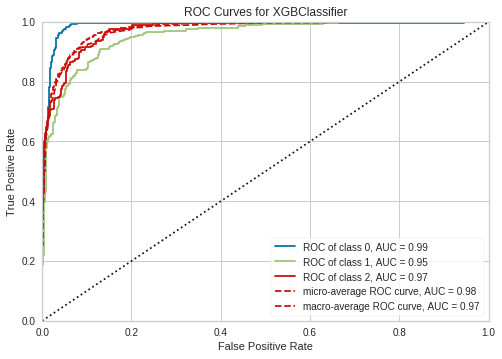

In [29]:
from yellowbrick.classifier import ROCAUC

classes=[0,1,2]

# Instantiate the visualizer with the classification model
visualizer = ROCAUC(xgb, classes=classes)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

# **Conclusion**

* **This can be useful to train our own players in the game and help them find their best position on the field.**
* **Next step can be specifying the precise position**

